<a href="https://colab.research.google.com/github/yohanesnuwara/volve-machine-learning/blob/main/notebook/SWave_prediction_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S-Wave Prediction Benchmarking for IEEE Paper

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

%config InlineBackend.figure_format = 'retina'

!pip install lasio
import lasio
import glob

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam

In [12]:
!git clone https://github.com/yohanesnuwara/volve-machine-learning

fatal: destination path 'volve-machine-learning' already exists and is not an empty directory.


In [13]:
# Create dataframe of all wells

list_df = [] 
for f in glob.glob('/content/volve-machine-learning/well_logs/*.LAS'):
  name = f.split('/')[-1][:-4]
  las = lasio.read(f)
  las_df = las.df().reset_index(drop=True)
  wellname = np.full(len(las_df), name)
  las_df['WELL'] = wellname
  list_df.append(las_df)

# Merge all dataframes
df = pd.concat(list_df)

df.head(10)

,ABDCQF01,ABDCQF02,ABDCQF03,ABDCQF04,BS,CALI,DRHO,GR,NBGRCFM,NPHI,...,RD,RHOB,RM,ROP,RPCEHM,RPCELM,RT,WELL,DT,DTS
0,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15_9-F-1C,NaN,NaN
1,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15_9-F-1C,NaN,NaN
2,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15_9-F-1C,NaN,NaN
3,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15_9-F-1C,NaN,NaN
4,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15_9-F-1C,NaN,NaN
5,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15_9-F-1C,NaN,NaN
6,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15_9-F-1C,NaN,NaN
7,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15_9-F-1C,NaN,NaN
8,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15_9-F-1C,NaN,NaN
9,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15_9-F-1C,NaN,NaN


In [14]:
# Only select training data
df = df[(df.WELL=='15_9-F-11A') | (df.WELL=='15_9-F-1A') | (df.WELL=='15_9-F-1B')]

# Only select important columns
df = df[['WELL', 'CALI', 'DRHO', 'GR', 'NPHI', 'PEF', 'RACEHM', 'RACELM', 
         'RHOB', 'ROP', 'RPCEHM', 'RPCELM', 'RT', 'DT', 'DTS']]

df

,WELL,CALI,DRHO,GR,NPHI,PEF,RACEHM,RACELM,RHOB,ROP,RPCEHM,RPCELM,RT,DT,DTS
0,15_9-F-11A,NaN,NaN,4.300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15_9-F-11A,NaN,NaN,3.801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15_9-F-11A,NaN,NaN,4.301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15_9-F-11A,NaN,NaN,4.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15_9-F-11A,NaN,NaN,4.599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33186,15_9-F-1B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.9836,NaN,NaN,NaN,NaN,NaN
33187,15_9-F-1B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.9767,NaN,NaN,NaN,NaN,NaN
33188,15_9-F-1B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.9699,NaN,NaN,NaN,NaN,NaN
33189,15_9-F-1B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.9903,NaN,NaN,NaN,NaN,NaN


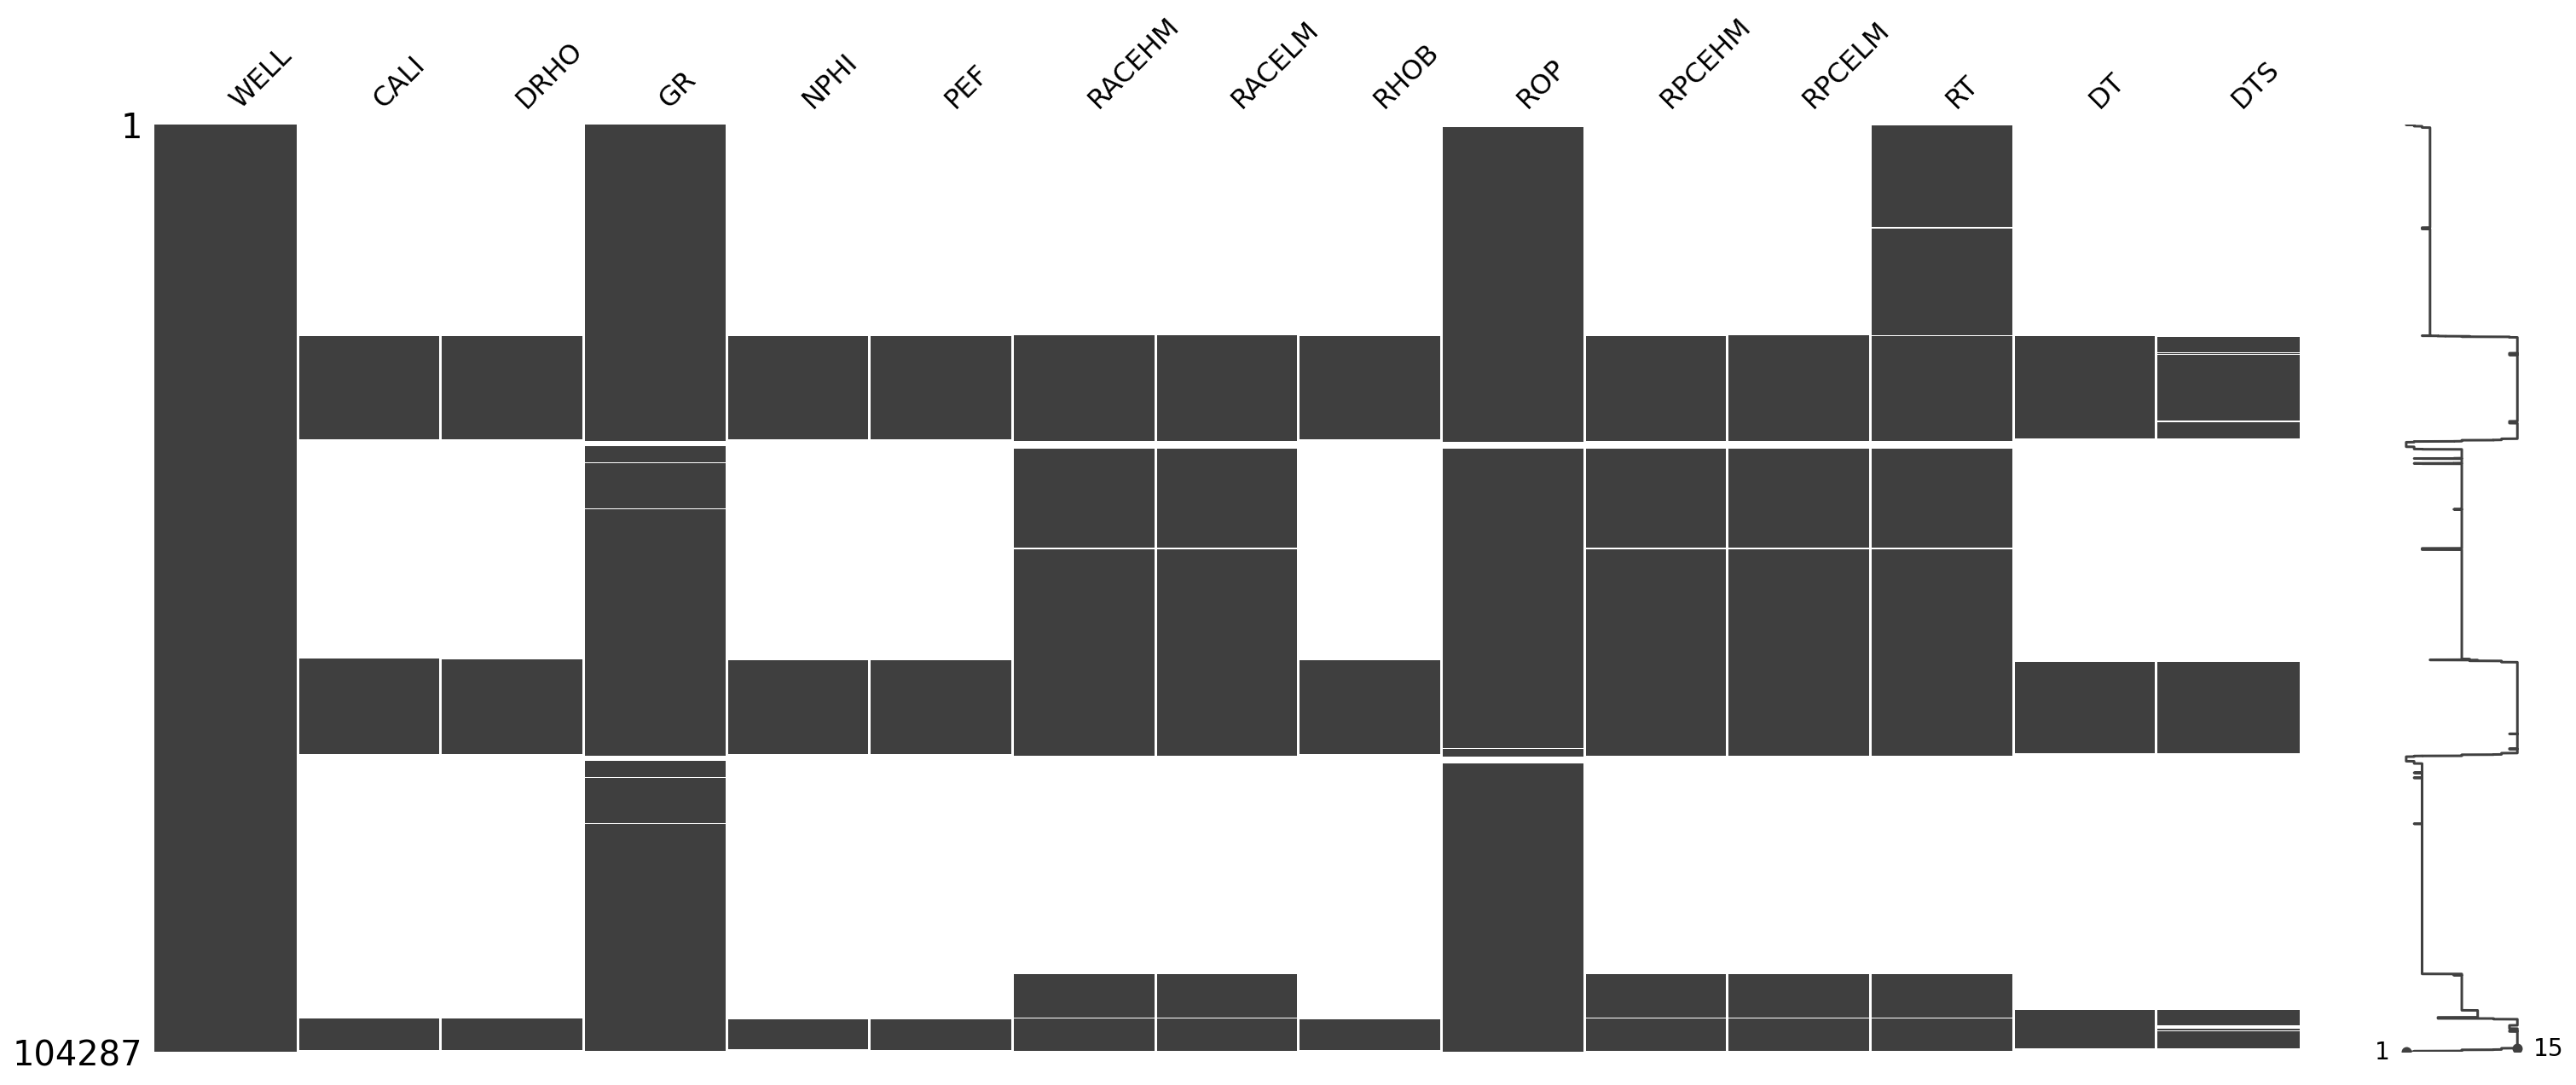

In [15]:
msno.matrix(df)

In [16]:
# Retain dataframe where DT and DTS is available
df = df.dropna(subset=['DT', 'DTS'])

# Drop all missing values
df = df.dropna()

df

,WELL,CALI,DRHO,GR,NPHI,PEF,RACEHM,RACELM,RHOB,ROP,RPCEHM,RPCELM,RT,DT,DTS
23944,15_9-F-11A,8.5780,0.0540,55.1860,0.3520,6.8290,0.8870,0.8700,2.3260,14.5840,1.2460,1.0760,0.7810,107.0670,261.0360
23945,15_9-F-11A,8.5780,0.0560,57.0150,0.3640,6.8100,0.8620,0.8600,2.3250,14.8340,1.1990,1.0470,0.7720,107.8100,260.1610
23946,15_9-F-11A,8.5780,0.0570,58.9230,0.3700,6.7760,0.7870,0.8410,2.3210,14.8850,1.2100,1.0330,0.7050,108.2310,261.0670
23947,15_9-F-11A,8.5630,0.0590,57.3220,0.3670,6.7220,0.7170,0.8170,2.3120,14.9360,1.2470,1.0150,0.6540,108.4280,262.5100
23948,15_9-F-11A,8.5780,0.0600,53.0540,0.3500,6.6380,0.7360,0.8100,2.2980,14.9870,1.1480,0.9680,0.6110,108.2220,263.3600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32783,15_9-F-1B,8.7231,0.0557,51.6833,0.1875,6.2810,1.1323,1.1919,2.4461,29.9912,1.1323,1.1774,1.1323,76.4480,136.8919
32784,15_9-F-1B,8.7483,0.0579,52.9685,0.1850,6.3838,1.1583,1.2003,2.4506,29.9845,1.1693,1.1964,1.1693,76.1982,136.7067
32785,15_9-F-1B,8.7485,0.0603,54.0012,0.1785,6.4731,1.2221,1.2139,2.4563,29.9778,1.1792,1.2145,1.1792,75.8560,136.5749
32786,15_9-F-1B,8.7735,0.0603,52.6933,0.1777,6.5220,1.2616,1.2312,2.4590,29.9621,1.2081,1.2347,1.2081,75.5494,135.3308


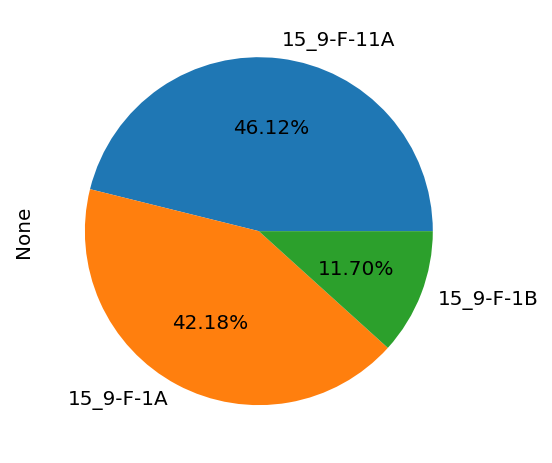

In [17]:
# Contribution of each well in training data
df.groupby('WELL').apply(len).plot(kind='pie', autopct='%.2f%%')

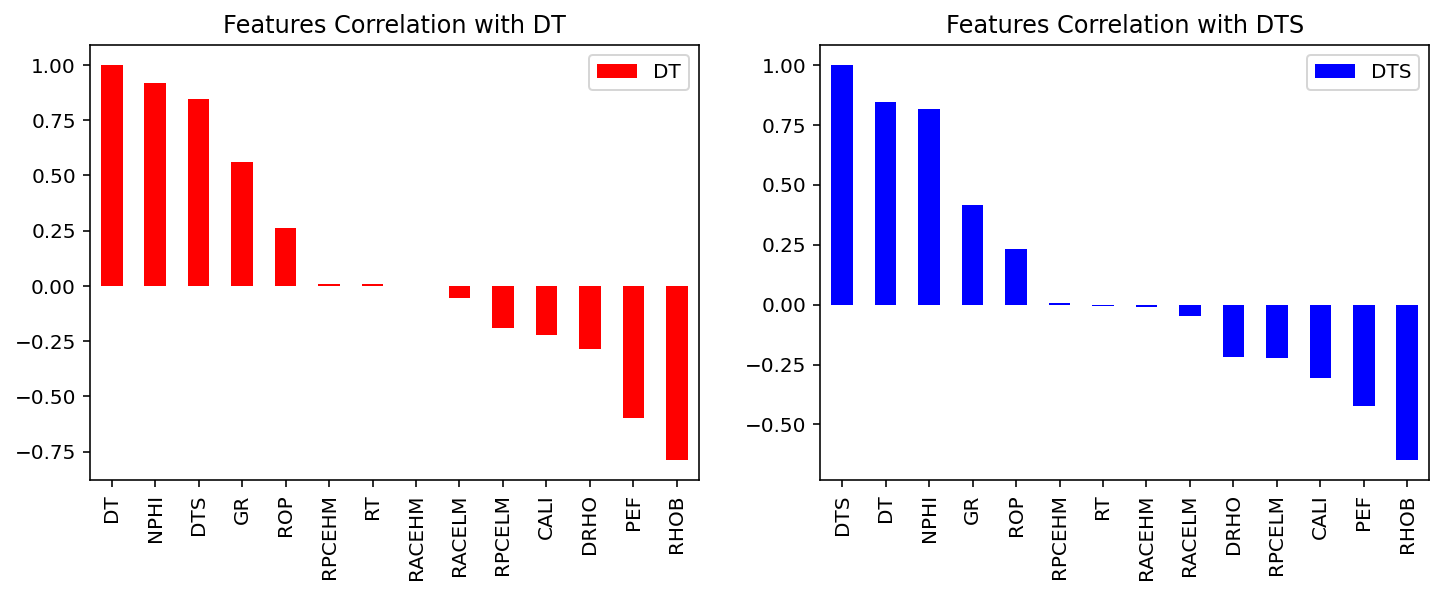

In [18]:
# Calculate correlation of features with targets
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,4))

df.corr()[['DT']].sort_values(by='DT', ascending=False).\
plot(kind='bar', color='r', ax=ax0, title='Features Correlation with DT')

df.corr()[['DTS']].sort_values(by='DTS', ascending=False).\
plot(kind='bar', color='b', ax=ax1, title='Features Correlation with DTS')
plt.show()

## Multi Linear Regression

In [39]:
# Define features and target
X = df.drop(columns=['WELL', 'DT', 'DTS'])
y = df.DTS

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

# Make pipeline
pipe = make_pipeline(StandardScaler(), LinearRegression())
model = pipe.fit(X, y)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(model[1].coef_)
print(model[1].intercept_)
print('Train RMSE:', mean_squared_error(y_train, y_train_pred, squared=False))
print('Train R2:', r2_score(y_train, y_train_pred))
print('Test RMSE:', mean_squared_error(y_test, y_test_pred, squared=False))
print('Test R2:', r2_score(y_test, y_test_pred))

[-4.45136678  0.96327711 -7.37573591 32.08266679  1.55413635 -0.08681039
 -0.55944342 -2.44311338 -0.31350466  2.98548195 -1.27563822 -2.05259334]
142.77594338617732
Train RMSE: 18.608026079087317
Train R2: 0.7206665669091117
Test RMSE: 18.170314009193497
Test R2: 0.7323269739424927


(83.853, 331.111)

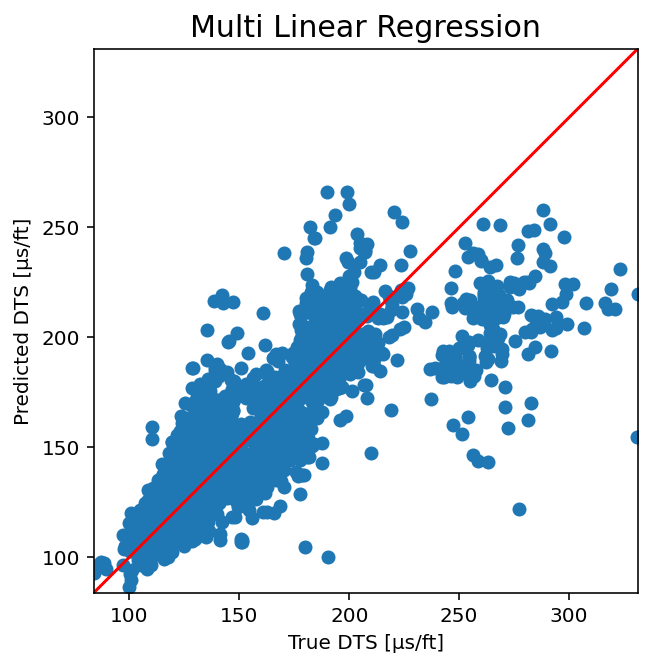

In [40]:
plt.figure(figsize=(5,5))

x0, x1 = y_test.min(), y_test.max()
plt.plot([x0,x1], [x0,x1], c='r')
plt.scatter(y_test, y_test_pred)
plt.gca().set_aspect('equal')
plt.title('Multi Linear Regression', size=15)
plt.xlabel('True DTS [μs/ft]')
plt.ylabel('Predicted DTS [μs/ft]')
plt.xlim(x0,x1)
plt.ylim(x0,x1)

## Random Forest

In [41]:
# Define features and target
X = df.drop(columns=['WELL', 'DT', 'DTS'])
y = df.DTS

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

# Make pipeline
pipe = make_pipeline(StandardScaler(), RandomForestRegressor())
model = pipe.fit(X, y)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('Train RMSE:', mean_squared_error(y_train, y_train_pred, squared=False))
print('Train R2:', r2_score(y_train, y_train_pred))
print('Test RMSE:', mean_squared_error(y_test, y_test_pred, squared=False))
print('Test R2:', r2_score(y_test, y_test_pred))

Train RMSE: 2.5564771583310235
Train R2: 0.994727626841466
Test RMSE: 2.511060382019933
Test R2: 0.9948879622103105


(83.853, 331.111)

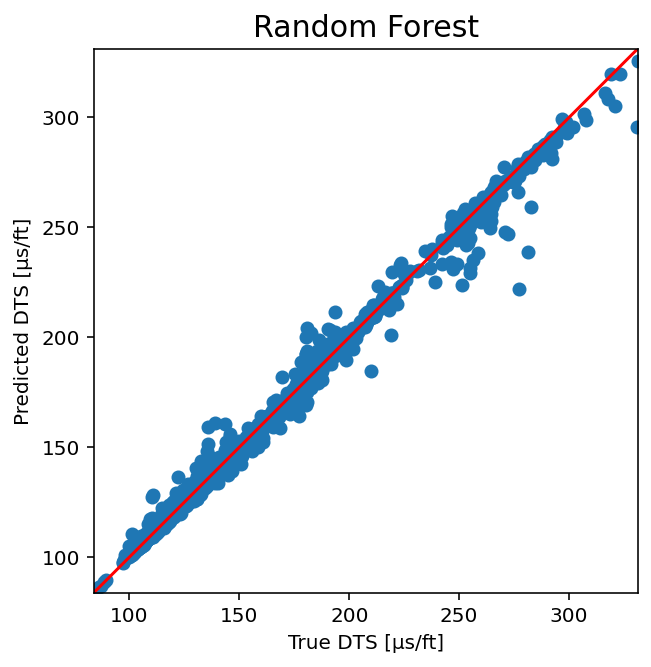

In [42]:
plt.figure(figsize=(5,5))

x0, x1 = y_test.min(), y_test.max()
plt.plot([x0,x1], [x0,x1], c='r')
plt.scatter(y_test, y_test_pred)
plt.gca().set_aspect('equal')
plt.title('Random Forest', size=15)
plt.xlabel('True DTS [μs/ft]')
plt.ylabel('Predicted DTS [μs/ft]')
plt.xlim(x0,x1)
plt.ylim(x0,x1)

## Dense Neural Network

In [32]:
# Create model
model = Sequential([
          Dense(300, activation='relu', kernel_initializer='normal', input_shape=(12,)), 
          # BatchNormalization(),
          Dense(250, kernel_initializer='normal', activation='relu' ),  
          # BatchNormalization(),
          Dense(200, kernel_initializer='normal', activation='relu' ), 
          # BatchNormalization(),
          Dense(150, kernel_initializer='normal', activation='relu' ), 
          # BatchNormalization(),                  
          Dense(100, kernel_initializer='normal', activation='relu' ),
          # BatchNormalization(),
          Dense(50, kernel_initializer='normal', activation='relu' ),
          # BatchNormalization(),          
          Dense(1, kernel_initializer='normal')]
)

# opt = SGD(learning_rate=0.1, momentum=0.1)
opt = 'adam'
# opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mean_squared_error')

model_checkpoint = ModelCheckpoint('best_model', monitor='val_loss', mode='min', 
                                   save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, validation_split=0.3, batch_size=64,
                    epochs=100, callbacks=[model_checkpoint])

Epoch 1/100
204/211 [============================>.] - ETA: 0s - loss: 309623.9062
Epoch 1: val_loss improved from inf to 14276.02734, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets
211/211 [==============================] - 4s 14ms/step - loss: 300793.9062 - val_loss: 14276.0273
Epoch 2/100
209/211 [============================>.] - ETA: 0s - loss: 5717.2026
Epoch 2: val_loss improved from 14276.02734 to 2145.22192, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets
211/211 [==============================] - 3s 14ms/step - loss: 5686.8232 - val_loss: 2145.2219
Epoch 3/100
210/211 [============================>.] - ETA: 0s - loss: 1189.1154
Epoch 3: val_loss improved from 2145.22192 to 1167.36584, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets
211/211 [==============================] - 3s 14ms/step - loss: 1188.4923 - val_loss: 1167.3658
Epoch 4/100
204/211 [============================>.] - 

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               3900      
                                                                 
 dense_1 (Dense)             (None, 250)               75250     
                                                                 
 dense_2 (Dense)             (None, 200)               50200     
                                                                 
 dense_3 (Dense)             (None, 150)               30150     
                                                                 
 dense_4 (Dense)             (None, 100)               15100     
                                                                 
 dense_5 (Dense)             (None, 50)                5050      
                                                                 
 dense_6 (Dense)             (None, 1)                 5

Text(0, 0.5, 'RMSE')

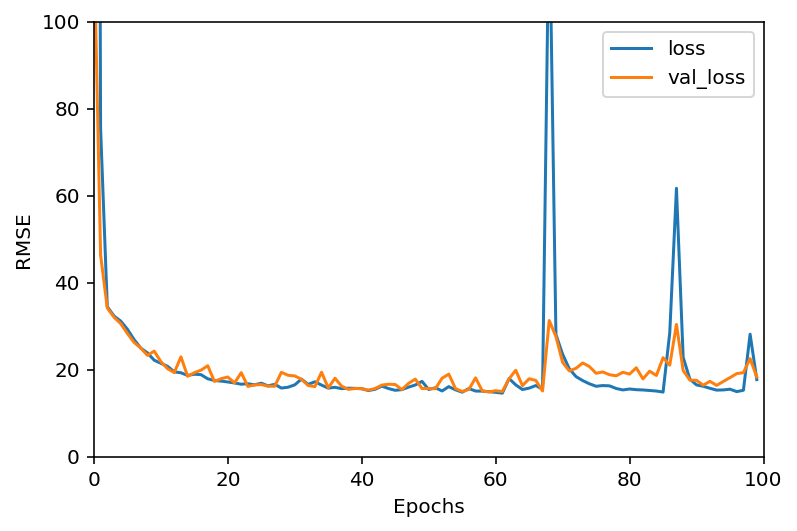

In [34]:
# Plotting in RMSE
def plot_model_history(history):
    fig, axes = plt.subplots(nrows=1, ncols=1)
    axes.plot(np.sqrt(history.history['loss']))   
    axes.plot(np.sqrt(history.history['val_loss']))
    axes.legend(['loss', 'val_loss'])

plot_model_history(history)
plt.xlim(0,100)
plt.ylim(0,100)
plt.xlabel('Epochs')
plt.ylabel('RMSE')

In [36]:
y_test_pred = model.predict(X_test)

print('Test RMSE:', mean_squared_error(y_test, y_test_pred, squared=False))
print('Test R2:', r2_score(y_test, y_test_pred))

Test RMSE: 17.24068400200602
Test R2: 0.7590157122999467


(83.853, 331.111)

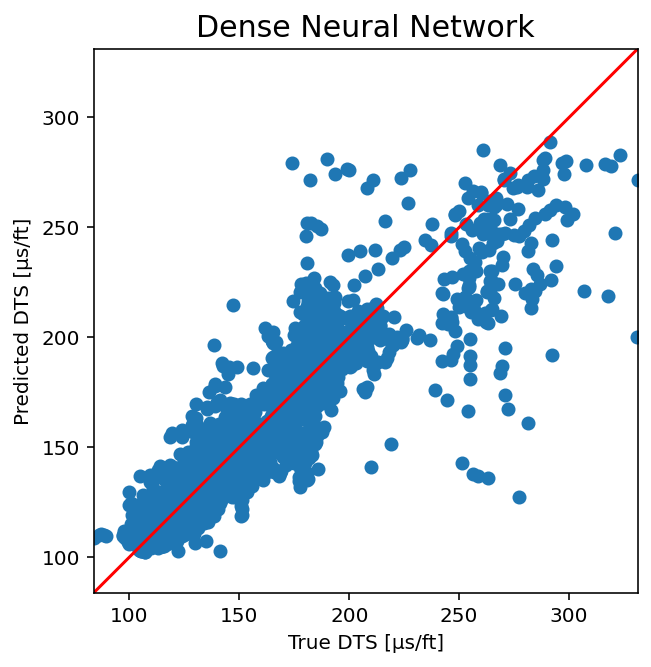

In [69]:
plt.figure(figsize=(5,5))

x0, x1 = y_test.min(), y_test.max()
plt.plot([x0,x1], [x0,x1], c='r')
plt.scatter(y_test, y_test_pred)
plt.gca().set_aspect('equal')
plt.title('Dense Neural Network', size=15)
plt.xlabel('True DTS [μs/ft]')
plt.ylabel('Predicted DTS [μs/ft]')
plt.xlim(x0,x1)
plt.ylim(x0,x1)